In [103]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
from utils import *
from linear_sca import * 

In [116]:
def get_PSTH(epoch):
    config_rf_ls = ['Ar', 'Ag', 'Br', 'Bg']
    leaders = []
    supporters = []
    for config_rf in config_rf_ls:
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Leaders/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            leaders.append(np.vstack(data[i]))
        
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Supporters/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            supporters.append(np.vstack(data[i]))
        
        
    np.stack(leaders)
    np.stack(supporters)
    return np.concatenate((leaders, supporters))


DotsOn = get_PSTH('DotsOn')
LibSacc = get_PSTH('LibSacc')
Slib = get_PSTH('Slib')
LastFix = get_PSTH('LastFix')
ChoiceSacc = get_PSTH('ChoiceSacc')
X = np.concatenate((DotsOn, LibSacc, Slib, LastFix, ChoiceSacc), axis=2).swapaxes(0,1)
X_sca, _ = pre_processing(X, soft_normalize='churchland', num_pcs=10)

In [123]:
X.shape

(12, 250, 150)

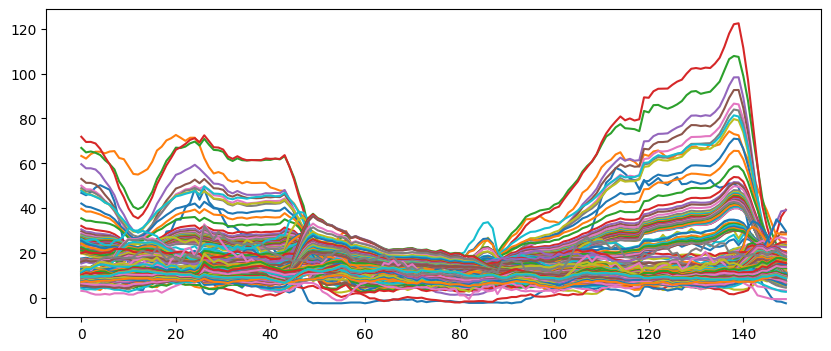

In [126]:
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.plot( X[-1,i,:] )

In [120]:
d = 2
wandb.init(project="SCA-project", name="run_1", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X_sca, d=d, iterations=1000, learning_rate=0.01) # iterations, learning_rate, d               
wandb.finish()

Iteration 0, S: 3.5330896377563477, S_ratio: 0.20671112835407257
Iteration 10, S: 3.9943928718566895, S_ratio: 0.21140506863594055
Iteration 20, S: 5.914838790893555, S_ratio: 0.21221095323562622
Iteration 30, S: 8.723526000976562, S_ratio: 0.19254176318645477
Iteration 40, S: 12.152713775634766, S_ratio: 0.16784198582172394
Iteration 50, S: 18.798490524291992, S_ratio: 0.1404174119234085
Iteration 60, S: 24.835647583007812, S_ratio: 0.12870611250400543
Iteration 70, S: 31.370786666870117, S_ratio: 0.1144707128405571
Iteration 80, S: 35.45751190185547, S_ratio: 0.12308749556541443
Iteration 90, S: 36.567562103271484, S_ratio: 0.12631219625473022
Iteration 100, S: 37.806846618652344, S_ratio: 0.1362444907426834
Iteration 110, S: 37.856475830078125, S_ratio: 0.14258892834186554
Iteration 120, S: 41.43119812011719, S_ratio: 0.14156971871852875
Iteration 130, S: 41.742122650146484, S_ratio: 0.14592505991458893
Iteration 140, S: 45.77771759033203, S_ratio: 0.15020716190338135
Iteration 150,

variance captured ratio 0.61
s: 0.14317341148853302


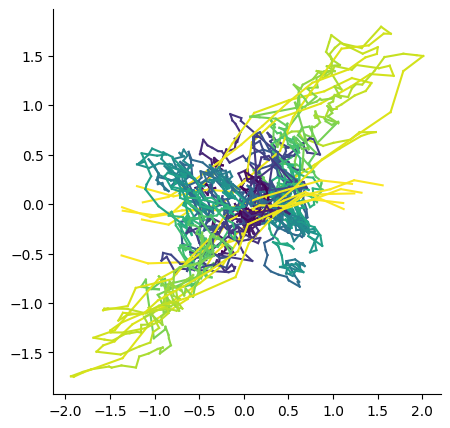

In [121]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_sca[:,:,:])         #(K,d,T) 

print(f"variance captured ratio {var_explained(X_sca, U_qr):.2f}")
print(f's: {compute_S_all_pairs(Y)}')
plot_2D(Y)